In [4]:
import pandas as pd
import numpy as np

In [3]:
data_path = "data/Loan_Data.csv"
df = pd.read_csv(data_path)
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [27]:
dev, val, holdout = np.split(
    df.sample(frac=1, random_state=1),
              [
                  int(.5 * len(df)), 
                  int(.8 * len(df))
              ]
    )

len(dev)

C:\Users\User\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


5000

In [28]:
df.default

0       0
1       1
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: default, Length: 10000, dtype: int64

In [29]:
# Check for sampling errors
print(f"""
Population Default Rate: {round(sum(df.default) * 100 / len(df), 2)}%
Development Sample Default Rate: {round(sum(dev.default) * 100 / len(dev), 2)}%
Validation Sample Default Rate: {round(sum(val.default) * 100 / len(val), 2)}%
Holdout Sample Default Rate: {round(sum(holdout.default) * 100 / len(holdout), 2)}%
""")


Population Default Rate: 18.51%
Development Sample Default Rate: 18.48%
Validation Sample Default Rate: 18.8%
Holdout Sample Default Rate: 18.15%



As seen, simple random sampling is effective in sampling for default rates. Alternatively, we can use stratified random sampling to make the default rate for each group (i.e., development, validation and holdout) more consistent.

In [22]:
from sklearn.model_selection import train_test_split as tts

In [30]:
dev, temp = tts(
    df, 
    test_size = 0.5, 
    stratify = df.default,
    random_state = 1
)

In [31]:
val, holdout = tts(
    temp,
    test_size = 0.4,
    stratify = temp.default,
    random_state = 1
)

In [33]:
print(f"""
Population Default Rate: {round(sum(df.default) * 100 / len(df), 2)}%
Development Sample Default Rate: {round(sum(dev.default) * 100 / len(dev), 2)}%
Validation Sample Default Rate: {round(sum(val.default) * 100 / len(val), 2)}%
Holdout Sample Default Rate: {round(sum(holdout.default) * 100 / len(holdout), 2)}%
""")


Population Default Rate: 18.51%
Development Sample Default Rate: 18.5%
Validation Sample Default Rate: 18.53%
Holdout Sample Default Rate: 18.5%



### Single-variable Logistic Regression Model

In [36]:
import statsmodels.formula.api as sm
import statsmodels.api as sma

my_logit = sm.glm(  # GLM = Generalized Linear Model
    formula = "default ~fico_score", data = dev,
    family = sma.families.Binomial()
).fit()

my_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2113.2
Date:                Fri, 08 Aug 2025   Deviance:                       4226.4
Time:                        16:17:32   Pearson chi2:                 5.01e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1064
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2123      0.441     18.616      0.000       7.348       9.077
fico_score    -0.0156      0.001    -21.608      0.000      -0.017      -0.014
==============================================================================
"""

In [37]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid(8.2123 - 0.0156)

0.9997245144892916

In [38]:
dev.describe(include = "all")

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,4.924076e+06,1.463600,4166.299904,8780.301994,70033.145403,4.552000,638.119000,0.185000
std,2.288148e+06,1.741862,1435.044371,6698.144495,20164.543357,1.561084,60.405399,0.388336
min,1.000324e+06,0.000000,57.348647,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.913551e+06,0.000000,3135.359986,4192.718392,56686.278268,3.000000,598.000000,0.000000
50%,4.932271e+06,1.000000,4052.171922,6756.589651,70220.565090,5.000000,638.000000,0.000000
75%,6.871387e+06,2.000000,5058.564804,11496.912522,83316.641957,6.000000,679.000000,0.000000
max,8.996751e+06,5.000000,10467.732060,43688.784100,145404.751500,10.000000,850.000000,1.000000


### Outlier Treatment

Text(0.5, 0, 'fico_score')

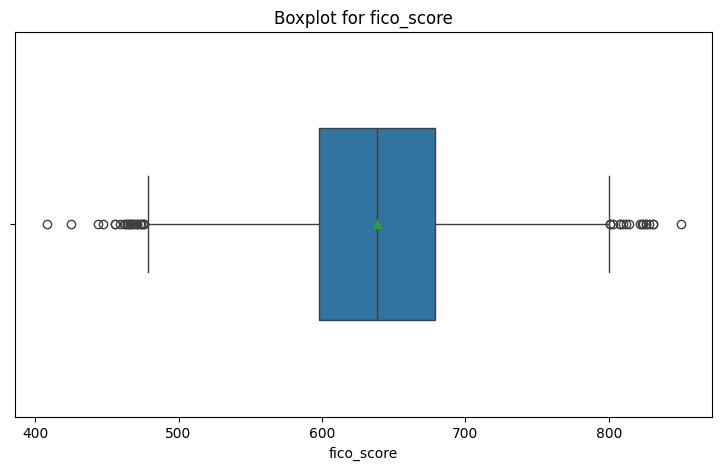

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns  # built on top of plt for better visualization
%matplotlib inline

x = "fico_score"
plt.figure(figsize=(9,5))
boxplot = sns.boxplot(
    x = x,
    data = dev,
    showmeans = True,
    width = 0.5, 
    # palette = "colorblind"
)
plt.title(f"Boxplot for {x}")
plt.xlabel(f"{x}")

Notes:
- As expected, income and fico score have similar boxplots. 
-  Common treatment for outliers is to equate them to their corresponding control limits (e.g., upper, lower)

### Missing Value Imputation

In [50]:
missing_df = df.isnull().sum(axis=0)
missing_df

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

We have a complete dataset. Otherwise, there are various imputation methods:
- initiate NAs to zero
- central measures of tendency (e.g., mean, median, mode)
- k-nearest neighbors
- regression